# Prévisions météo en Australie

# Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

Requirement already up-to-date: imblearn in /Users/gensteele/opt/anaconda3/lib/python3.8/site-packages (0.0)


In [3]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

# from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Modèles de classification par apprentissage supervisé

In [5]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [6]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [7]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [8]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [9]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Cardinalité des classes de la variable cible sous-échantillonnée:", dict(pd.Series(y_train_ru).value_counts()))

Cardinalité des classes de la variable cible sous-échantillonnée: {1: 25005, 0: 25005}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_train_ru.value_counts(normalize=True)

1    0.5
0    0.5
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Forêts Aléatoires

In [12]:
# définition du modèle
clf_rf  = RandomForestClassifier() # les forêts aléatoires ne gèrent pas les variables qualitatives

param_grid_rf  = [{'n_estimators' : [50, 100, 150],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf)

In [13]:
start_time = time.time()

# entraînement
gcv_rf.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150} 

Accuracy Score: 0.8573052063356772 

Train Data Score: 0.9705049321222776
Test Data Score: 0.8573052063356772

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20993   969
1             3049  3147
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21962
           1       0.76      0.51      0.61      6196

    accuracy                           0.86     28158
   macro avg       0.82      0.73      0.76     28158
weighted avg       0.85      0.86      0.85     28158

Running Time: 0:36:41.820528


In [14]:
cv_scores = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.84897318 0.85059798 0.85216951]
Average cross-validation score: 0.8505802235658667


L'accuracy de la modele est tres bien mais il y a evidence de 'Overtraining'. 

Concernant l'interpretabilite de la modele ca situe quelque part entre un whitebox (comme un simple arbre de decision) et un vrai blackbox comme un nueral network. (Un greybox peut-etre?). 

L'outil le plus utiliser pour intepreter les resultats du modele est encore des features importances.

Utilisant le best-estimator d'avant nous commencons pars regarder les features importance calcule on regardant la moyen diminuation d'impurite pour tous les arbres dans notre foret.

Text(0, 0.5, 'Mean decrease in impurity')

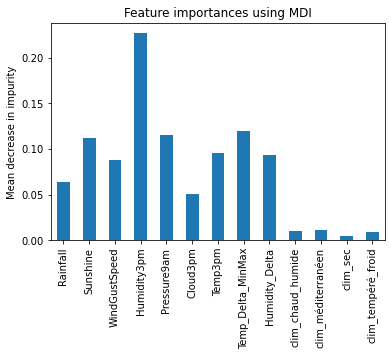

In [15]:
#access 
importances = gcv_rf.best_estimator_.feature_importances_
# cast
forest_importances = pd.Series(importances, index=data.columns)
# plot
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Comme nous avons vu pour les autres modeles, Humidity3pm est le feature le plus important. 

Cela etant dit il y a deux problemes avec les method MDI pour trouver les features importances:

- Ca utilise le modele lui meme et donc si le modele a des problems d'overtraining ca peut avoir un effet dans les features importances aussi

- il y a un bias pour les features numerique ou avec un grande cardinalite.

Il exist un autre method qui a pas ces problemes: Permutation Importance. C'est calcule sur le test data. Les features sont melanger 'n' fois et la modele est 'refitted' pour estimer l'importance. Ce method est donc, bien sur, plus lourd en temps de calcul.

Text(0, 0.5, 'Mean accuracy decrease')

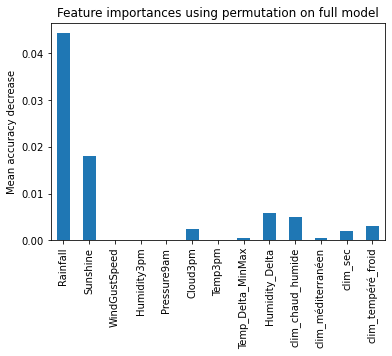

In [20]:
# import module necessaire
from sklearn.inspection import permutation_importance
# calcule
result = permutation_importance(
    gcv_rf.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
#cast
forest_importances2 = pd.Series(abs(result.importances_mean), index=data.columns)
#plot
fig, ax = plt.subplots()
forest_importances2.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")

Avec ce method on voit que Rainfall a devenu le feature le plus important. On apercu aussi un example d'un des problemes avec ce method. Humidity3pm a tombe a zero qui est bizarre on connaisant les autres resultats. Le mechanism de ce method gere pas tres bien l'importance des features qui sont correlle - qui est le cas pour Humidity3pm et Humidity_Delta.